**BSMプロセスでのオプション計算**  
**(1) Basic (Fig 6.7)**

In [1]:
import QuantLib as ql ; import myUtil as mu ; from myABBR import * 

# 初期値 - pC: ql.Option.Call=1, Put=-1
tradeDT,                      matDT,         pC                       =\
mu.iDT('2023-10-27'), mu.iDT('2023-11-10'),  -1    ;mu.setEvDT(tradeDT)

spotPRC, strkPRC,  volRT,  dvdRT,  rfRT,  Premium, Greek             =\
31000,    28000,   0.2821,  0.03,  0.000,   0.0,   'NPV'

# 4つのハンドル, 確率過程, エンジン
spotHDL      = mu.sqHDL  (spotPRC)
_,dvdHDL     = mu.ffTSH  (tradeDT, dvdRT)    
rfOBJ,rfHDL  = mu.ffTSH  (tradeDT,  rfRT)
volHDL       = mu.bVolTSH(tradeDT, volRT)
bsmPROC  = ql.BlackScholesMertonProcess(spotHDL, dvdHDL, rfHDL, volHDL)
anaENG  = ql.AnalyticEuropeanEngine(bsmPROC)
# オプション    
optOBJ  = ql.VanillaOption(ql.PlainVanillaPayoff(pC, strkPRC), 
                                            ql.EuropeanExercise(matDT))
optOBJ.setPricingEngine(anaENG)
#プレミアムの初期値調整 - vol計算の為
if Premium == 0.0: Premium = optOBJ.NPV()  
# 計算
greeks = {"NPV": optOBJ.NPV(), "delta": optOBJ.delta(), "gamma": optOBJ.gamma(),
         "vega": optOBJ.vega(),"theta": optOBJ.thetaPerDay(),
         "vol": optOBJ.impliedVolatility(Premium, bsmPROC)}
print(greeks['NPV'])

21.992715701826796


In [2]:
# keys()でのプリント例
for grk in greeks.keys(): 
    print('{}: {:.4f}'.format(grk, greeks[grk]), end=', ')

NPV: 21.9927, delta: -0.0322, gamma: 0.0000, vega: 437.7768, theta: -4.4926, vol: 0.2821, 

**(2) モンテカルロシミュレーション 1  (Fig 6.9)**

In [3]:
nPATH, nSTEP, nSeed   =\
10,      2,     3  
mcENG  = ql.MCEuropeanEngine(bsmPROC, "PseudoRandom", seed=nSeed,
                timeSteps=nSTEP, requiredSamples=nPATH) #, antitheticVariate=True)
optOBJ.setPricingEngine(mcENG)
optOBJ.NPV()

83.2950167431718

**(3) モンテカルロシミュレーション 2 (Fig 6.11)**

In [4]:
# 初期設定( mtrxPT:各パスのデータ保存用マトリックス)
mtrxPT,  itmAMT,          YRs                              =\
[],        0,    dcA365.yearFraction(tradeDT, matDT)

# RNG(Random Number Generator)設定
uniRNG    = ql.UniformRandomGenerator(nSeed)
uniSeqRNG = ql.UniformRandomSequenceGenerator(nSTEP, uniRNG)
gsSeqRNG  = ql.GaussianRandomSequenceGenerator(uniSeqRNG)
gsPathGN  = ql.GaussianPathGenerator(bsmPROC, YRs, nSTEP, gsSeqRNG, False) 

# 各パスのグリッドデータのmtrxPTへの保存(nextメソッドで乱数を発生、valueで値を取得)
for xx in range(nPATH):
    onePT = gsPathGN.next().value()     
    mtrxPT.append([onePT[i] for i in range(len(onePT))])
#最後のonePTから時間軸を作成 (timeメソッドで時間軸の値を取得)    
timeGRD = [onePT.time(i) for i in range(len(onePT))]
print('timeGRD  : ',timeGRD) ; print('mtrxPT[0]: ',mtrxPT[0])

# NPV計算 (imtAMT: In The Money Amount)
for i in range(nPATH):
   itmAMT += max( pC*(mtrxPT[i][-1] - strkPRC), 0)
print('optionNPV: ', itmAMT/nPATH * rfOBJ.discount(matDT))

timeGRD  :  [0.0, 0.019178082191780823, 0.038356164383561646]
mtrxPT[0]:  [31000.0, 31113.340710798053, 29337.136700258114]
optionNPV:  83.2950167431718


**パスのグラフ (Fig 6.12)**

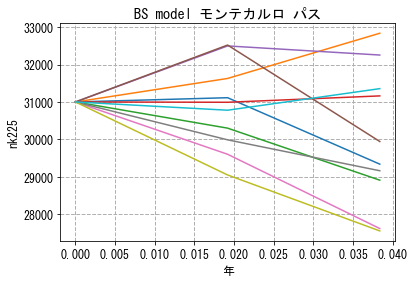

In [5]:
# パスのプロット
import matplotlib.pyplot as plt 
plt.rcParams.update({
    "font.family":"MS Gothic","font.size":12,"figure.figsize":[6,4]})

fig, ax = plt.subplots()
for i in range(nPATH): ax.plot(timeGRD, mtrxPT[i])
ax.set_title("BS model モンテカルロ パス")
ax.set_xlabel("年"); ax.set_ylabel("nk225")
ax.grid(linestyle='--',linewidth=1);    

**(4) 関数化 - xlwings**

In [6]:
import QuantLib as ql ; import xlwings as xw 
import myUtil as mu   ; from myABBR import * 
@xw.func
def bsOption(pC, tradeDT, matDT, spotPRC, strkPRC,
             volRT=0.01, dvdRT=0.01, rfRT=0.000, Premium=0.0, Greek='NPV'):
    ''' pC: ql.Option.Call=1, Put=-1 '''
    # 初期値 (xlwingsの為、pCを整数とした)
    tradeDT,         matDT,             pC                         =\
    mu.iDT(tradeDT), mu.iDT(matDT), int(pC) ;  mu.setEvDT(tradeDT)
    # ハンドルと確率過程
    spotHDL  = mu.sqHDL(spotPRC)
    _,dvdHDL = mu.ffTSH  (tradeDT, dvdRT)    
    _,rfHDL  = mu.ffTSH  (tradeDT,  rfRT)
    volHDL   = mu.bVolTSH(tradeDT, volRT)
    bsmPROC  = ql.BlackScholesMertonProcess(spotHDL, dvdHDL, rfHDL, volHDL)
    # オプション オブジェクト    
    optOBJ  = ql.VanillaOption(ql.PlainVanillaPayoff(pC, strkPRC), 
                               ql.EuropeanExercise(matDT))
    optOBJ.setPricingEngine(ql.AnalyticEuropeanEngine(bsmPROC))
    #プレミアムの初期値調整 - vol計算の為
    if Premium == 0.0: Premium = optOBJ.NPV()  
    # 計算
    greeks = {"NPV": optOBJ.NPV(), "delta": optOBJ.delta(), "gamma": optOBJ.gamma(),
             "vega": optOBJ.vega(),"theta": optOBJ.thetaPerDay(),
              "vol": optOBJ.impliedVolatility(Premium, bsmPROC)}
    return greeks[Greek]

In [7]:
#            pC,   tradeDT,      matDT,    spotPRC, strkPRC
basePRM = ( -1,    '2023-10-27', '2023-11-10',  31000,  28000)
#           volRT, dvdRT,  rfRT
grkPRM  = (0.2821, 0.03,  0.0001)
# NPV
print('putCall: ', basePRM[0], end=', ')
print(  f'NPV:{bsOption(*basePRM, *grkPRM, Greek="NPV"  ):,.4f}')
# greeks
print(f'delta:{bsOption(*basePRM, *grkPRM, Greek="delta"):,.4f}', end=', ')
print(f'gamma:{bsOption(*basePRM, *grkPRM, Greek="gamma"):,.4f}', end=', ')
print( f'vega:{bsOption(*basePRM, *grkPRM, Greek="vega" ):,.4f}', end=', ')
print(f'theta:{bsOption(*basePRM, *grkPRM, Greek="theta"):,.4f}', end=', ')
print(  f'vol:{bsOption(*basePRM, *grkPRM, Greek="vol"  ):,.4%}')
# vol calculation at NPV=22 
print('vol at Premium=22:', end=' ')
print(      f'{bsOption(*basePRM, *grkPRM, Premium=22, Greek="vol" ):,.3%}')


putCall:  -1, NPV:21.9888
delta:-0.0322, gamma:0.0000, vega:437.7206, theta:-4.4918, vol:28.2101%
vol at Premium=22: 28.213%
